In [1]:
using FFTW, LinearAlgebra, EllipsisNotation, FunctionOperators, PaddedViews, Base.Cartesian
using MacroTools, BenchmarkTools, ProgressMeter, Distributed
include("jim.jl");

In [2]:
include("SigJl.jl")

Main.SigJl

In [3]:
using PyCall, Libdl
Libdl.dlopen(ENV["HOME"]*"/.local/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so",
    Libdl.RTLD_DEEPBIND);

In [4]:
np = pyimport("numpy")

sp = pyimport("sigpy")
mr = pyimport("sigpy.mri")
pl = pyimport("sigpy.plot")

pushfirst!(PyVector(pyimport("sys")."path"), "")
dd = pyimport("python.download_dataset")
gr = pyimport("python.gridding_recon")
reconImage = pyimport("python.multi_scale_low_rank_image")
recon = pyimport("python.multi_scale_low_rank_recon")

device = 0;

In [5]:
dd.download_dce_dataset()

ksp = np.load("data/dce/ksp.npy")
coord = np.load("data/dce/coord.npy")
dcf = np.load("data/dce/dcf.npy");

In [6]:
num_ro = 100  # number of readout points
ksp_py = ksp[:, :, 1:num_ro]
ksp_j = permutedims(ksp_py, (1, 3, 2))
coord_py = coord[:, 1:num_ro, :]
coord_j = permutedims(coord_py, (3, 2, 1))
dcf_py = dcf[:, 1:num_ro]
dcf_j = permutedims(dcf_py, (2, 1))
ksp, coord, dcf = fill(nothing, 3);

In [7]:
FFTW.set_num_threads(40)

In [8]:
""" Gridding reconstruction.

Args:
    ksp (array): k-space measurements of shape (C, num_tr, num_ro), where
        C is the number of channels,
        num_tr is the number of TRs, and
        num_ro is the readout points.
    coord (array): k-space coordinates of shape (num_tr, num_ro, D), where
        D is the number of spatial dimensions.
    dcf (array): density compensation factor of shape (num_tr, num_ro).
    T (int): number of frames.

Returns:
    img (array): image of shape (T, N_D, ..., N_1).
"""
function gridding_recon(ksp, coord, dcf, T=1)
    # calculate size parameters
    C, num_ro, num_tr = size(ksp)
    D = size(coord, 1)
    tr_per_frame = num_tr ÷ T
    points_per_frame = tr_per_frame * num_ro
    
    # reshape arrays for batch processing
    ksp = reshape(ksp, C, T, points_per_frame)
    coord = reshape(coord, D, T, points_per_frame)
    dcf = reshape(dcf, 1, T, points_per_frame)
    
    # Here happens the "magic"
    img = abs2.(SigJl.nufft_adjoint(coord, ksp .* dcf))
            #progressTitle="Gridding reconstruction", progress_dt=0.2))
    
    # sum along coils and take square root
    return sqrt.(sum(img, dims=1))
end

gridding_recon

In [10]:
@time grd_julia = gridding_recon(ksp_j, coord_j, dcf_j);

  1.233757 seconds (4.19 M allocations: 1008.034 MiB, 5.85% gc time)


In [12]:
@time grd_python = gr.gridding_recon(ksp_py, coord_py, dcf_py, device=0);

  0.674135 seconds (78 allocations: 267.250 KiB)


In [13]:
print("absolute error: ", norm(grd_julia - grd_python, Inf), "\n",
    "relative error: ", norm((grd_julia - grd_python) ./ grd_python, Inf))

absolute error: 6.229966e-5
relative error: 0.032021042

In [14]:
function visualize(img; slice)
    jim(permutedims(img[:,slice,end:-1:1,end:-1:1], (3,2,1)), abswarn=false)
end

visualize (generic function with 1 method)

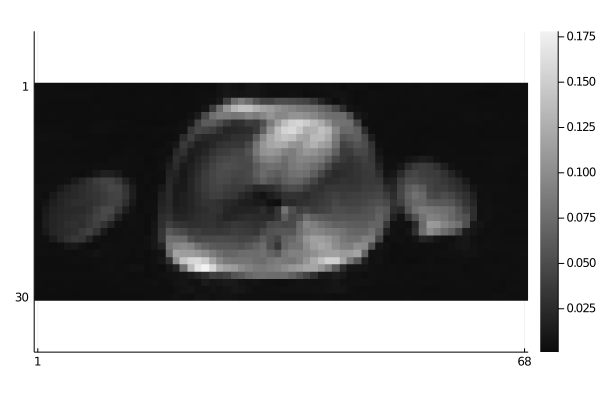

In [15]:
visualize(grd_julia, slice=16)

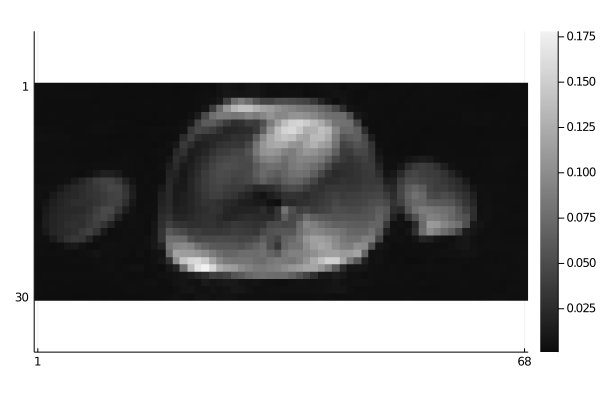

In [16]:
visualize(grd_python, slice=16)

In [17]:
mps = np.load("data/dce/mps.npy");
#mps = mr.app.JsenseRecon(ksp, coord=coord, weights=dcf, device=device).run()
#np.save("data/dce/mps.npy", mps)

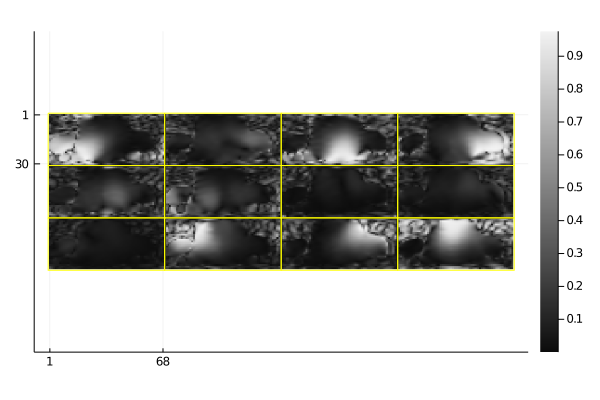

In [18]:
visualize(mps, slice=16)

In [19]:
T = 100
lamda = 1e-8
blk_widths = [8, 16, 32]  # For low resolution.

3-element Array{Int64,1}:
  8
 16
 32

In [18]:
@time img_py = recon.MultiScaleLowRankRecon(ksp, coord, dcf, mps, T, lamda, max_epoch=1,
    device=device, blk_widths=blk_widths).run();

PowerIter L 5/5: 100%|███████████████████████| 100/100 [00:05<00:00, 17.53it/s]

 72.230267 seconds (1.02 M allocations: 50.161 MiB)


In [19]:
img_py.use_device(device)

In [20]:
Img_py = vcat([img_py.__getitem__(t) for t in 0:T-1]);

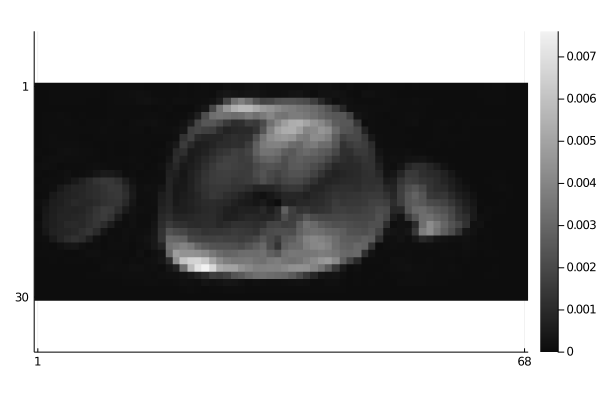

In [21]:
visualize(Img_py[80,..], slice=16)

In [20]:
@generated function blocks_to_array!(
        output::AbstractArray{T, D},
        input::AbstractArray{T, D2},
        block_shape::NTuple{D, Int},
        shifts::NTuple{D, Int}) where {T, D, D2}
    @assert 2*D == D2 "Dimension mismatch! Proper dimensionality: 2*ndims(output) = ndims(input)"
    quote
        @nloops($D, block_idx, input, begin
                @nloops($D, point_idx, d -> axes(input, $D + d),
                    d -> begin
                        pos_in_output_d = (block_idx_d - 1) * shifts[d] + point_idx_d
                        pos_in_output_d > size(output, d) && break
                    end,
                    @inbounds @nref($D, output, pos_in_output) +=
                        input[@ntuple($D, block_idx)..., @ntuple($D, point_idx)...])
            end)
        return output
    end
end

blocks_to_array! (generic function with 1 method)

In [21]:
@generated function array_to_blocks!(
        output::AbstractArray{T, D2},
        input::AbstractArray{T, D},
        block_shape::NTuple{D, Int},
        shifts::NTuple{D, Int}) where {T, D, D2}
    @assert 2*D == D2 "Dimension mismatch! Proper dimensionality: ndims(output) = 2*ndims(input)"
    quote
        @nloops($D, block_idx, output, begin
                @nloops($D, point_idx, d -> axes(output, $D + d),
                    d -> pos_in_output_d = (block_idx_d - 1) * shifts[d] + point_idx_d,
                    @inbounds output[@ntuple($D, block_idx)..., @ntuple($D, point_idx)...] = 
                        @nany($D, d -> pos_in_output_d > size(input, d)) ?
                            zero($T) :
                            @nref($D, input, pos_in_output))
            end)
        return output
    end
end

array_to_blocks! (generic function with 1 method)

In [22]:
function hanning(shape)
    shape = shape isa Number ? (shape,) : shape
    hanningFunction(x, width) = 0.5 - 0.5 * cos(2π * x / max(1, (width - (width % 2))))
    multiDimHanning(coord) = prod([hanningFunction(coord[i]-1, shape[i]) for i in 1:length(shape)])
    [multiDimHanning(coord) for coord in CartesianIndices(tuple(UnitRange.(1, shape)...))]
end

hanning (generic function with 1 method)

In [23]:
# Some fancy stuff for naming
#   e.g. the array-to-block operator for the scale with block-size 8 as "𝓑₈"
digitToSubscript(d) = string(Char(Int('₀')+d))
numberToSubscript(n) = join([digitToSubscript(Int(d)-48) for d in string(n)])

numberToSubscript (generic function with 1 method)

In [24]:
function _get_𝓜(block_width, img_shape, dtype)
    
    block_shape = min.(img_shape, block_width)
    shifts = (block_shape .+ 1) .÷ 2
    num_blocks = ceil.(Int, img_shape ./ shifts .- 1)
    ndim = length(num_blocks)
    
    # Blocking operator:
    #  - forward embeds blocks in the output image in a sliding window manner
    #  - backward rearranges the image to blocks
    𝓑 = FunctionOperator{dtype}(name = "𝓑"*numberToSubscript(block_width),
        forw = (b, x) -> begin
            b .= zero(dtype)
            blocks_to_array!(b, x, block_shape, shifts)
        end,
        backw = (b, x) -> array_to_blocks!(b, x, block_shape, shifts),
        inDims = (num_blocks..., block_shape...),
        outDims = img_shape)
    
    # Multiplication with Hanning window to cancel the effect of sliding window.
    # Blocks are multiplied with the squre root of the window before and after the blocking operator.
    HanningWindow = reshape(sqrt.(hanning(block_shape)), fill(1, ndim)..., block_shape...)
    𝓦 = FunctionOperator{dtype}(name = "𝓦"*numberToSubscript(block_width),
        forw = (b, x) -> b .= x .* HanningWindow,
        backw = (b, x) -> b .= x .* HanningWindow,
        inDims = (num_blocks..., block_shape...),
        outDims = (num_blocks..., block_shape...))
    
    return 𝓑 * 𝓦
end

_get_𝓜 (generic function with 1 method)

In [42]:
function _get_𝓐(t, coordₜ, kspₜ, dcfₜ, mps, img_shape, C, num_ro, tr_per_frame, dtype)    
    FunctionOperator{dtype}(name = "𝓐"*numberToSubscript(t),
        forw = (kspₜ, frame) -> begin
                frame = reshape(frame, 1, size(frame)...) .* mps
                SigJl.nufft!(kspₜ, coordₜ[t], frame, oshape=img_shape)
                kspₜ .*= sqrt.(dcfₜ[t])
            end,
        backw = (frame, kspₜ) -> begin
                frame_coils = SigJl.nufft_adjoint(coordₜ[t], kspₜ .* sqrt.(dcfₜ[t]), oshape=(C, img_shape...))
                frame_coils .*= conj.(mps)
                sum!(reshape(frame, 1, size(frame)...), frame_coils)
                frame
            end,
        inDims = img_shape,
        outDims = size(kspₜ[1]))
end

_get_𝓐 (generic function with 1 method)

In [26]:
py"""
from math import ceil
import sigpy as sp
import numpy as np
"""

In [27]:
function _get_λ(block_width, img_shape, T, dtype)
    
    block_shape = min.(img_shape, block_width)
    shifts = (block_shape .+ 1) .÷ 2
    num_blocks = ceil.(Int, img_shape ./ shifts .- 1)
    
    Nⱼ = prod(block_shape)
    Bⱼ = prod(num_blocks)
    
    return √Nⱼ + √T + √(2log(Bⱼ))
end

_get_λ (generic function with 1 method)

In [28]:
function MaxEig!(op, x, iter_num)
    λₘₐₓ = Inf
    #@showprogress 0.2 "Normalization of dcf... "
    for i in 1:iter_num
        mul!(x, op, x)
        λₘₐₓ = norm(x, 2)
        x ./= λₘₐₓ
    end
    λₘₐₓ
end

MaxEig! (generic function with 1 method)

In [49]:
function _normalize(coord, dcf, ksp, mps, img_shape, C, T, tr_per_frame, max_power_iter, dtype)
    
    # Estimate maximum eigenvalue.
    print("Normalization of dcf:\t\t\t")
    @time begin
        coord_t₁ = @view coord[:, :, 1:tr_per_frame]
        dcf_t₁ = reshape(@view(dcf[:, 1:tr_per_frame]), 1, :, tr_per_frame)
        plan = SigJl.nufft_plan(coord_t₁, img_shape)
        adj_plan = plan'
        𝓝₁ = FunctionOperator{dtype}(name = "𝓝₁",
            forw = (b, x) -> mul!(b, plan, x),
            backw = (b, x) -> mul!(b, adj_plan, x),
            inDims = img_shape,
            outDims = size(coord_t₁))
        𝓓₁ = FunctionOperator{dtype}(name = "𝓓₁",
            forw = (b, x) -> b .= x .* dcf_t₁,
            inDims = size(coord_t₁),
            outDims = size(coord_t₁))
        x₀ = convert.(eltype(ksp), rand(img_shape...))
        λₘₐₓ = MaxEig!(𝓝₁' * 𝓓₁ * 𝓝₁, x₀, max_power_iter)
        dcf ./= abs(λₘₐₓ)
    end
    
    # Estimate scaling
    print("Normalization of ksp:\t\t\t")
    @time begin
        dcf = reshape(dcf, 1, size(dcf)...)
        img = SigJl.nufft_adjoint(coord, ksp .* dcf, oshape=(C, img_shape...))
                #progressTitle="Normalization of ksp... ", progress_dt=0.2)
        img .*= conj.(mps)
        ksp ./= norm(sum(img, dims=1), 2)
    end
    
    dcf, ksp
end

_normalize (generic function with 1 method)

In [30]:
function normalize_L!(L)
    D = ndims(L) ÷ 2
    L_norm = mapslices(norm, L, dims=D+1:2D)
    L ./= L_norm
    L_norm
end

normalize_L! (generic function with 1 method)

In [31]:
function normalize_R!(R)
    R ./= mapslices(norm, R, dims=ndims(R))
end

normalize_R! (generic function with 1 method)

In [32]:
function _init_L(blocked_shape, dtype)
    L = randn(dtype, blocked_shape)
    normalize_L!(L)
    L
end

_init_L (generic function with 1 method)

In [33]:
function _init_R(blocked_shape, D, T, dtype)
    Array{dtype}(undef, (blocked_shape[1:D]..., fill(1, D)..., T))
end

_init_R (generic function with 1 method)

In [43]:
function powerIter_R!(Rⱼ, t, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, Lⱼ, D)
    Aₜᴴyₜ = 𝓐ₜ[t]' * (kspₜ[t] .* sqrt.(dcfₜ[t]))
    for j in 1:length(Rⱼ)
        AₜᴴyₜLⱼᴴ = (𝓜ⱼ[j]' * Aₜᴴyₜ) .*= conj.(Lⱼ[j])
        Rⱼ[j][.., t] .= mapslices(norm, AₜᴴyₜLⱼᴴ, dims=D+1:2D)
    end
end

powerIter_R! (generic function with 1 method)

In [44]:
function powerIter_L!(Lⱼ, t, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, Rⱼ)
    Aₜᴴyₜ = 𝓐ₜ[t]' * (kspₜ[t] .* sqrt.(dcfₜ[t]))
    for j in 1:length(Lⱼ)
        Lⱼ[j] .+= (𝓜ⱼ[j]' * Aₜᴴyₜ) .* conj.(@view(Rⱼ[j][.., t]))
    end
end

powerIter_L! (generic function with 1 method)

In [ ]:
deepcopy

In [67]:
function _power_method!(Lⱼ, Rⱼ, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, D, max_power_iter, dtype)
    
    σ = nothing
    
    for it in 1:max_power_iter
        # Rⱼₜ = calc_norm_of_blocks(𝓜ⱼᴴ(Aₜᴴ⋅yₜᴴ)⋅Lⱼᴴ)
        p = Progress(T, 0.2, "Power iteration (R, $it/$max_power_iter)... ")
        Threads.@threads for t in 1:T
            powerIter_R!(Rⱼ, t, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, Lⱼ, D)
            next!(p)
        end
        
        pmap(normalize_R!, Rⱼ)
        
        # Lⱼ = Σₜ(𝓜ⱼᴴ(Aₜᴴ⋅yₜᴴ)⋅Rⱼₜᴴ)
        Threads.@threads for L in Lⱼ
            fill!(L, zero(dtype))
        end
        Lⱼ_threaded = (Lⱼ, [deepcopy(Lⱼ) for _ in 2:Threads.nthreads()]...)
        p = Progress(T+1, 0.2, "Power iteration (L, $it/$max_power_iter)... ")
        Threads.@threads for t in 1:T
            powerIter_L!(Lⱼ_threaded[Threads.threadid()], t, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, Rⱼ)
            next!(p)
        end
        for i in 2:Threads.nthreads()
            for j in 1:length(Lⱼ)
                Lⱼ[j] .+= Lⱼ_threaded[i][j]
            end
        end
        next!(p)
        
        σ = pmap(normalize_L!, Lⱼ) # save the norm of L at each level
    end

    Threads.@threads for j in 1:length(Lⱼ)
        Lⱼ[j] .*= sqrt.(σ[j])
        Rⱼ[j] .*= sqrt.(σ[j])
    end
    
    σ
end

_power_method! (generic function with 1 method)

In [68]:
function MultiScaleLowRankRecon(
        ksp, coord, dcf, mps, T, λ;
        block_widths=[32, 64, 128], α=1, β=0.5, sgw=nothing,
        seed=0, max_epoch=60, decay_epoch=20, max_power_iter=5,
        show_pbar=true)
    
    ## --- Initialization --- ##
    dtype = eltype(ksp)
    C, num_ro, num_tr = size(ksp)
    tr_per_frame = num_tr ÷ T
    img_shape = size(mps)[2:end]
    D = length(img_shape)
    J = length(block_widths)
    
    !(sgw isa Nothing) && (dcf .*= resize(sgw, size(sgw)..., 1))
    dcf, ksp = _normalize(coord, copy(dcf), copy(ksp), mps,
                    img_shape, C, T, tr_per_frame, max_power_iter, dtype)
    
    get_frame_range(t) = ((t - 1) * tr_per_frame + 1):(t * tr_per_frame)
    coordₜ = [@view coord[:,:,get_frame_range(t)] for t in 1:T]
    kspₜ = [@view(ksp[:,:,get_frame_range(t)]) for t in 1:T]
    dcfₜ = [@view dcf[:,:,get_frame_range(t)] for t in 1:T]
    
    print("create blocking operators:\t\t")
    @time 𝓜ⱼ = [_get_𝓜(bw, img_shape, dtype) for bw in block_widths]
    print("create acquisition operators:\t\t")
    @time 𝓐ₜ = [_get_𝓐(t, coordₜ, kspₜ, dcfₜ, mps, img_shape, C, num_ro, tr_per_frame, dtype) for t in 1:T]
    print("calculate regularization weights (λⱼ):  ")
    @time λⱼ = [_get_λ(bw, img_shape, T, dtype) for bw in block_widths]
    print("initialize Lⱼ:\t\t\t\t")
    @time Lⱼ_init = [_init_L(𝓜ⱼ[j].inDims, dtype) for j in 1:J]
    print("initialize Rⱼ:\t\t\t\t")
    @time Rⱼ_init = [_init_R(𝓜ⱼ[j].inDims, D, T, dtype) for j in 1:J]
    
    σ = _power_method!(Lⱼ, Rⱼ, 𝓐ₜ, 𝓜ⱼ, kspₜ, dcfₜ, D, max_power_iter, dtype)
end

MultiScaleLowRankRecon (generic function with 1 method)

In [70]:
@time σ = MultiScaleLowRankRecon(ksp_j, coord_j, dcf_j, mps, T, lamda,
    max_power_iter=1, max_epoch=1, block_widths=blk_widths);

Normalization of dcf:			  0.079658 seconds (44.67 k allocations: 45.840 MiB)
Normalization of ksp:			  1.483333 seconds (4.19 M allocations: 1004.899 MiB, 13.23% gc time)
create blocking operators:		  0.064546 seconds (318.70 k allocations: 11.359 MiB)
create acquisition operators:		  0.002446 seconds (10.09 k allocations: 599.031 KiB)
calculate regularization weights (λⱼ):    0.000008 seconds (3 allocations: 192 bytes)
initialize Lⱼ:				  0.033134 seconds (15.46 k allocations: 9.077 MiB)
initialize Rⱼ:				  0.000039 seconds (49 allocations: 784.500 KiB)


Power iteration (R, 1/1)... 100%|███████████████████████| Time: 0:00:13
Power iteration (L, 1/1)... 100%|███████████████████████| Time: 0:00:10


 25.517502 seconds (14.78 M allocations: 104.757 GiB, 38.05% gc time)


In [75]:
size(σ[1]), size(σ[2]), size(σ[3])

((8, 7, 16, 1, 1, 1), (4, 3, 8, 1, 1, 1), (2, 1, 4, 1, 1, 1))

In [82]:
r = recon.MultiScaleLowRankRecon(ksp_py, coord_py, dcf_py, mps, T, lamda, max_epoch=1,
    max_power_iter=1, device=device, blk_widths=blk_widths)


MaxEig: 100%|█████████████████| 1/1 [00:00<00:00, 120.17it/s, max_eig=1.80E+01]

PyObject <python.multi_scale_low_rank_recon.MultiScaleLowRankRecon object at 0x7f695ae88f98>

In [83]:
r._init_vars()

In [84]:
r._power_method()


PowerIter L 1/1: 100%|███████████████████████| 100/100 [00:05<00:00, 17.40it/s]

In [92]:
σ1_py = sp.to_device(r.sigma[1], sp.cpu_device)
σ2_py = sp.to_device(r.sigma[2], sp.cpu_device)
σ3_py = sp.to_device(r.sigma[3], sp.cpu_device);

In [95]:
norm(σ1_py, 2), norm(σ[1], 2)

(0.093617536f0, 0.10104409f0)

In [96]:
norm(σ2_py, 2), norm(σ[2], 2)

(0.08588073f0, 0.09338439f0)

In [98]:
norm(σ3_py, 2), norm(σ[3], 2)

(0.05388233f0, 0.06413252f0)

In [94]:
norm(σ1_py - σ[1], Inf), norm((σ1_py - σ[1]) ./ σ1_py, Inf)

(0.0037467908f0, 3.9972491f0)

In [99]:
norm(σ2_py - σ[2], Inf), norm((σ2_py - σ[2]) ./ σ2_py, Inf)

(0.009923733f0, 3.5825138f0)

In [100]:
norm(σ3_py - σ[3], Inf), norm((σ3_py - σ[3]) ./ σ3_py, Inf)

(0.011277374f0, 1.4571968f0)